In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip
  
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

--2019-11-05 16:39:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   122MB/s    in 1.2s    

2019-11-05 16:39:54 (122 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2019-11-05 16:39:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [2]:
import tensorflow as tf

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [3]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), 
                           activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), 
                           activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), 
                           activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, 
                          activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, 
                          activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [12]:
history = model.fit_generator(
                  train_generator,
                  steps_per_epoch=8,  
                  epochs=60,
                  verbose=1,
                  validation_data=validation_generator,
                  validation_steps=8)

Epoch 1/60
8/8 [==============================] - 35s 4s/step - loss: 0.4462 - acc: 0.7586 - val_loss: 0.6872 - val_acc: 0.5078
Epoch 2/60
8/8 [==============================] - 30s 4s/step - loss: 0.4783 - acc: 0.7408 - val_loss: 0.6751 - val_acc: 0.5078
Epoch 3/60
8/8 [==============================] - 28s 3s/step - loss: 0.4553 - acc: 0.7942 - val_loss: 0.7482 - val_acc: 0.5039
Epoch 4/60
8/8 [==============================] - 28s 3s/step - loss: 0.4930 - acc: 0.7720 - val_loss: 0.7214 - val_acc: 0.5039
Epoch 5/60
8/8 [==============================] - 31s 4s/step - loss: 0.4291 - acc: 0.7939 - val_loss: 0.6697 - val_acc: 0.5352
Epoch 6/60
8/8 [==============================] - 28s 3s/step - loss: 0.4155 - acc: 0.7987 - val_loss: 0.6461 - val_acc: 0.5586
Epoch 7/60
8/8 [==============================] - 25s 3s/step - loss: 0.4953 - acc: 0.7765 - val_loss: 0.6209 - val_acc: 0.6055
Epoch 8/60
8/8 [==============================] - 31s 4s/step - loss: 0.3896 - acc: 0.8271 - val_loss: 0

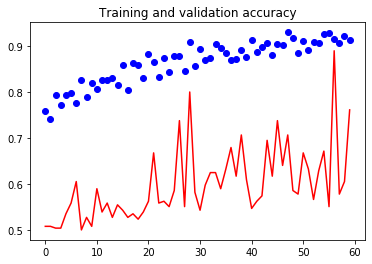

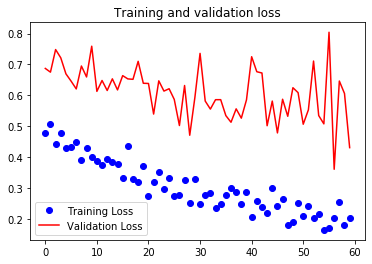

In [13]:
import matplotlib.pyplot as plt

# retrieve accuracy and loss for both training and test data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# see the reference for 'b' and 'bo' under markers: 
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()